✅ Files already found. Skipping upload.


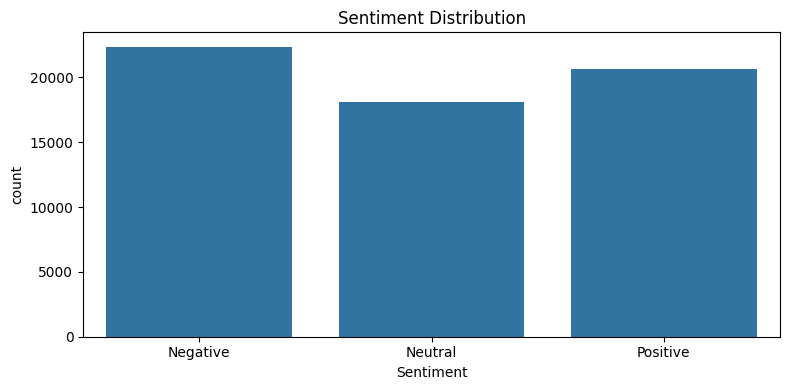

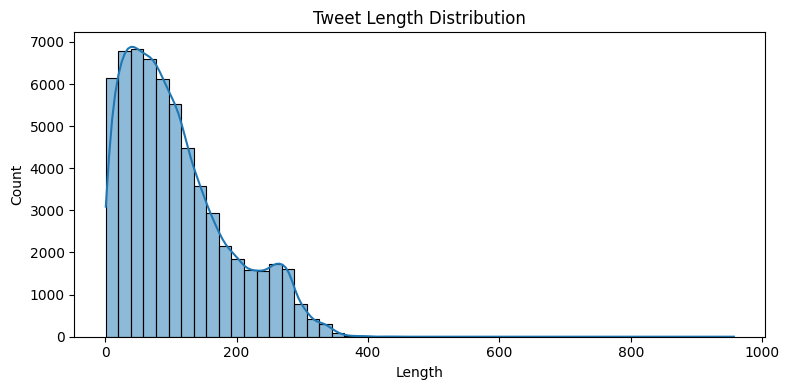

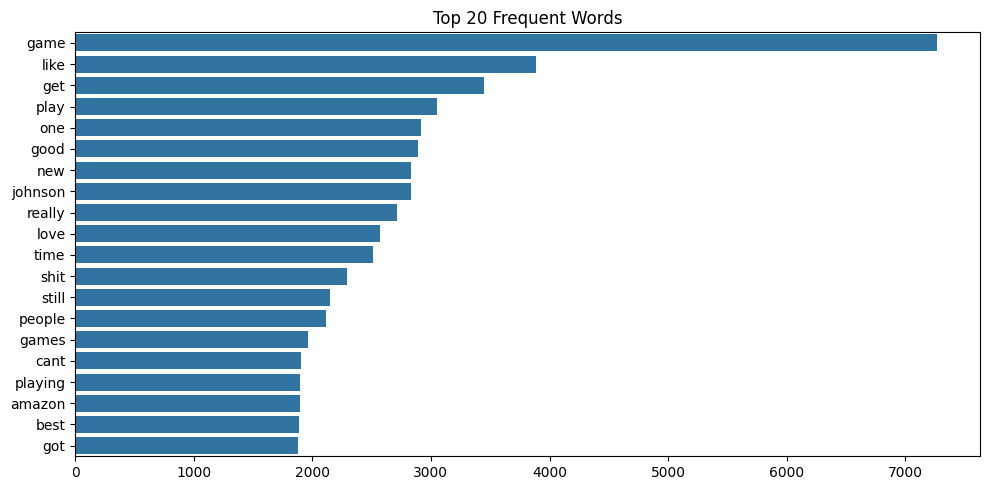


[Logistic Regression Test Accuracy] 0.7748875255623722
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4472
           1       0.72      0.72      0.72      3622
           2       0.79      0.78      0.78      4131

    accuracy                           0.77     12225
   macro avg       0.77      0.77      0.77     12225
weighted avg       0.77      0.77      0.77     12225



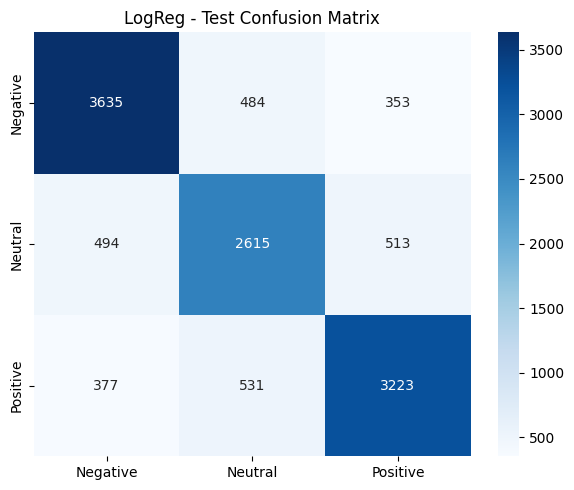


[Validation Accuracy - Logistic Regression] 0.8683574879227053
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       266
           1       0.90      0.82      0.86       285
           2       0.89      0.90      0.89       277

    accuracy                           0.87       828
   macro avg       0.87      0.87      0.87       828
weighted avg       0.87      0.87      0.87       828



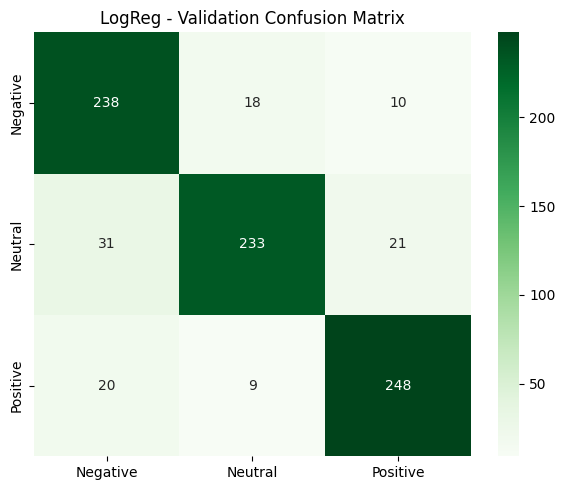

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Training DistilBERT model...


Step,Training Loss
500,0.800700
1000,0.681300
1500,0.626100
2000,0.562200
2500,0.534700
3000,0.481200
3500,0.438600
4000,0.348800
4500,0.266400
5000,0.256800



DistilBERT Evaluation Results: {'eval_loss': 0.135362446308136, 'eval_accuracy': 0.9734299516908212, 'eval_f1_negative': 0.9772727272727273, 'eval_f1_neutral': 0.9701230228471002, 'eval_f1_positive': 0.9731663685152058, 'eval_runtime': 2.6109, 'eval_samples_per_second': 317.136, 'eval_steps_per_second': 4.979, 'epoch': 3.0}


In [5]:
# ----------------------------
# FULL TWITTER SENTIMENT PIPELINE (Improved Upload Handling)
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

# ----------------------------
# Upload files only if not already in workspace
# ----------------------------
if not os.path.exists("twitter_training.csv") or not os.path.exists("twitter_validation.csv"):
    from google.colab import files
    print("📤 Upload both CSV files: twitter_training.csv and twitter_validation.csv")
    uploaded = files.upload()
else:
    print("✅ Files already found. Skipping upload.")

# ----------------------------
# Load datasets from uploaded files
# ----------------------------
train_df = pd.read_csv('twitter_training.csv', header=None, names=["Tweet_ID", "Entity", "Sentiment", "Content"])
val_df = pd.read_csv('twitter_validation.csv', header=None, names=["Tweet_ID", "Entity", "Sentiment", "Content"])

# ----------------------------
# Stopwords and Preprocessing
# ----------------------------
stopwords = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([w for w in text.split() if w not in stopwords and len(w) > 2])

# ----------------------------
# Clean & encode labels
# ----------------------------
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
train_df = train_df[train_df['Sentiment'].isin(label_map)].dropna(subset=['Content'])
val_df = val_df[val_df['Sentiment'].isin(label_map)].dropna(subset=['Content'])
train_df['Cleaned'] = train_df['Content'].apply(preprocess)
val_df['Cleaned'] = val_df['Content'].apply(preprocess)
train_df['Label'] = train_df['Sentiment'].map(label_map)
val_df['Label'] = val_df['Sentiment'].map(label_map)

# ----------------------------
# EDA
# ----------------------------
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df, x='Sentiment', order=label_map.keys())
plt.title("Sentiment Distribution")
plt.tight_layout()
plt.show()

train_df['Length'] = train_df['Content'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(train_df['Length'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.tight_layout()
plt.show()

all_words = ' '.join(train_df['Cleaned']).split()
word_freq = Counter(all_words).most_common(20)
words, freqs = zip(*word_freq)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Frequent Words")
plt.tight_layout()
plt.show()

# ----------------------------
# TF-IDF + Logistic Regression
# ----------------------------
X = train_df['Cleaned']
y = train_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

logreg = LogisticRegression(max_iter=500, C=1.0, solver='lbfgs')
logreg.fit(X_train_vec, y_train)
y_test_pred = logreg.predict(X_test_vec)

print("\n[Logistic Regression Test Accuracy]", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("LogReg - Test Confusion Matrix")
plt.tight_layout()
plt.show()

# ----------------------------
# Validation Evaluation (LogReg)
# ----------------------------
X_val_vec = vectorizer.transform(val_df['Cleaned'])
y_val = val_df['Label']
y_val_pred = logreg.predict(X_val_vec)

print("\n[Validation Accuracy - Logistic Regression]", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Greens', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("LogReg - Validation Confusion Matrix")
plt.tight_layout()
plt.show()

# ----------------------------
# DistilBERT Tokenization & Dataset
# ----------------------------
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
        self.labels = list(labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_df['Content'], train_df['Label'])
val_dataset = TweetDataset(val_df['Content'], val_df['Label'])

# ----------------------------
# DistilBERT Training Setup
# ----------------------------
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
training_args = TrainingArguments(
    output_dir="./distilbert_output",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = (preds == labels).mean()
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": acc,
        "f1_negative": report['0']['f1-score'],
        "f1_neutral": report['1']['f1-score'],
        "f1_positive": report['2']['f1-score']
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("\nTraining DistilBERT model...")
trainer.train()
distilbert_results = trainer.evaluate()
print("\nDistilBERT Evaluation Results:", distilbert_results)